# Wiki Fraud Detection - User Edits EDA

Exploratory data analysis of Wikipedia user editing patterns to identify vandalism behavior.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Style settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
non_revert_color = '#98FB98'
revert_color = '#FFA07A'

In [49]:
# Load and prepare data
df = pd.read_pickle("D:/generated_cv/wiki-fraud-detection/data/processed/wiki/user_edits_train.pkl")

# Basic data preprocessing
df["rev_time"] = df["rev_time"].apply(pd.to_datetime)
df["revert_rate"] = df["is_reverted_seq"].apply(lambda x: np.mean(x) if isinstance(x, list) and len(x) > 0 else np.nan)

print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nData types:\n{df.dtypes}")

Dataset shape: (20106, 9)
Missing values:
user_name             0
label                 0
edit_sequence         0
rev_time              0
is_reverted_seq       0
stiki_score_seq       0
cluebot_revert_seq    0
total_edits           0
revert_rate           0
dtype: int64

Data types:
user_name              object
label                   int64
edit_sequence          object
rev_time               object
is_reverted_seq        object
stiki_score_seq        object
cluebot_revert_seq     object
total_edits             int64
revert_rate           float64
dtype: object


## Label Distribution

Label distribution:
label
1    10209
0     9897
Name: count, dtype: int64
Imbalance ratio: 0.97:1


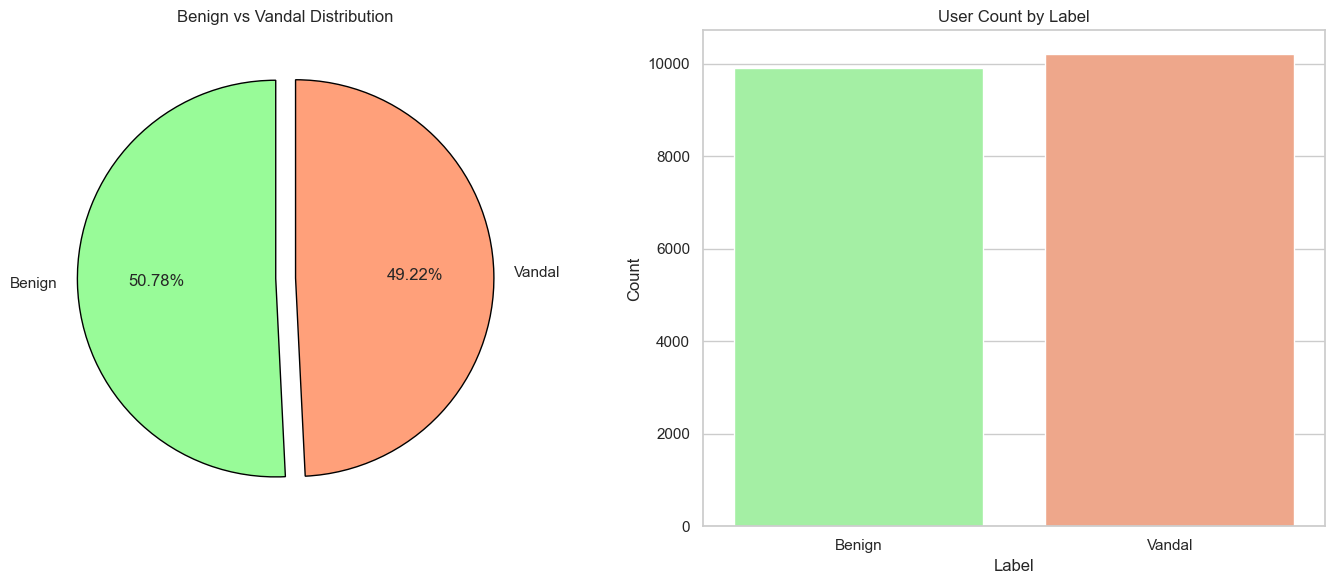

In [50]:
label_counts = df["label"].value_counts()
print(f"Label distribution:\n{label_counts}")
print(f"Imbalance ratio: {label_counts[0]/label_counts[1]:.2f}:1")

plt.figure(figsize=(14, 6))

# Pie chart
plt.subplot(1, 2, 1)
plt.pie(label_counts, labels=["Benign", "Vandal"], autopct="%1.2f%%", 
        colors=[non_revert_color, revert_color], explode=(0.05, 0.05), 
        startangle=90, wedgeprops=dict(edgecolor='black'))
plt.title("Benign vs Vandal Distribution")

# Bar plot
plt.subplot(1, 2, 2)
sns.countplot(x="label", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("User Count by Label")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Edit Behavior Analysis

In [51]:
# Calculate additional metrics
def compute_flat_length(seq):
    try:
        return sum(len(subelem) if isinstance(subelem, list) else 1 for subelem in seq)
    except:
        return np.nan

df["flattened_edit_len"] = df["edit_sequence"].apply(compute_flat_length)

# Max edit length per user
df["max_edit_length"] = df['edit_sequence'].apply(
    lambda seq: max([len(edit) for edit in seq]) if isinstance(seq, list) and len(seq) > 0 else 0
)

# Average edit length per user
df["avg_edit_length"] = df['edit_sequence'].apply(
    lambda seq: np.mean([len(edit) for edit in seq]) if isinstance(seq, list) and len(seq) > 0 else 0
)

print("Feature engineering complete.")

Feature engineering complete.


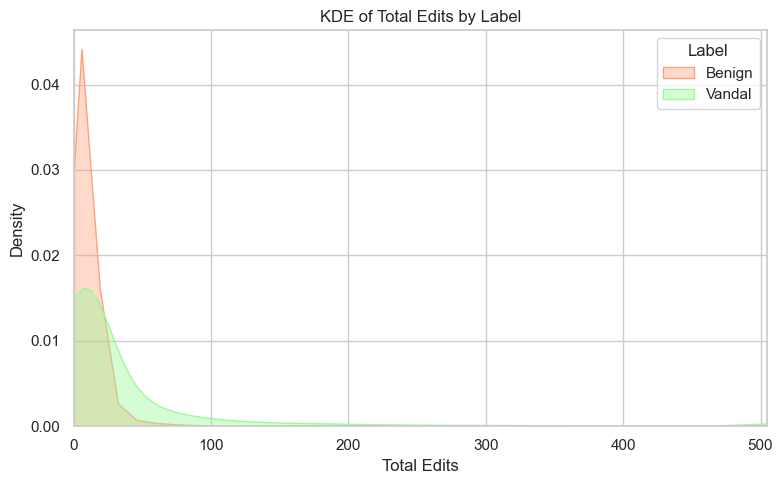

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=df,
    x='total_edits',
    hue='label',
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette={0: non_revert_color, 1: revert_color},
    bw_adjust=1.2  # Optional: smoothness
)

plt.title("KDE of Total Edits by Label")
plt.xlabel("Total Edits")
plt.ylabel("Density")
plt.legend(title="Label", labels=["Benign", "Vandal"])
plt.xlim(0, df['total_edits'].quantile(0.99))  # Optional: zoom in to ignore outliers
plt.tight_layout()
plt.show()


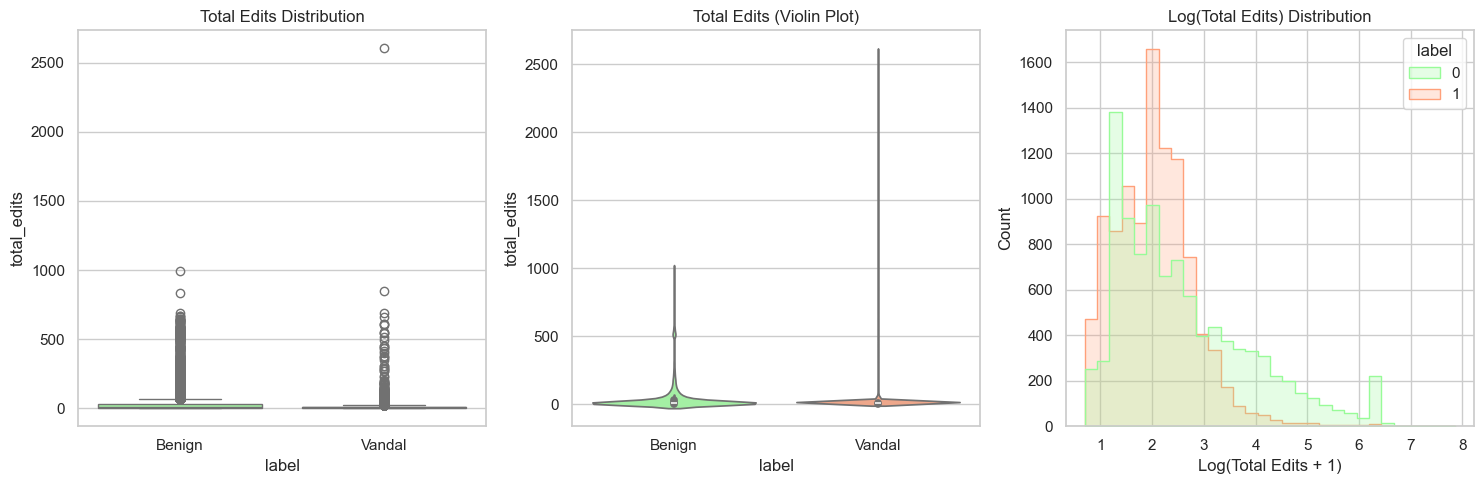

In [52]:
# Total edits comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="label", y="total_edits", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Total Edits Distribution")

plt.subplot(1, 3, 2)
sns.violinplot(x="label", y="total_edits", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Total Edits (Violin Plot)")

plt.subplot(1, 3, 3)
# Log scale for better visualization
df_log = df.copy()
df_log['log_total_edits'] = np.log1p(df_log['total_edits'])
sns.histplot(data=df_log, x="log_total_edits", hue="label", bins=30, 
             element="step", palette=[non_revert_color, revert_color])
plt.title("Log(Total Edits) Distribution")
plt.xlabel("Log(Total Edits + 1)")

plt.tight_layout()
plt.show()

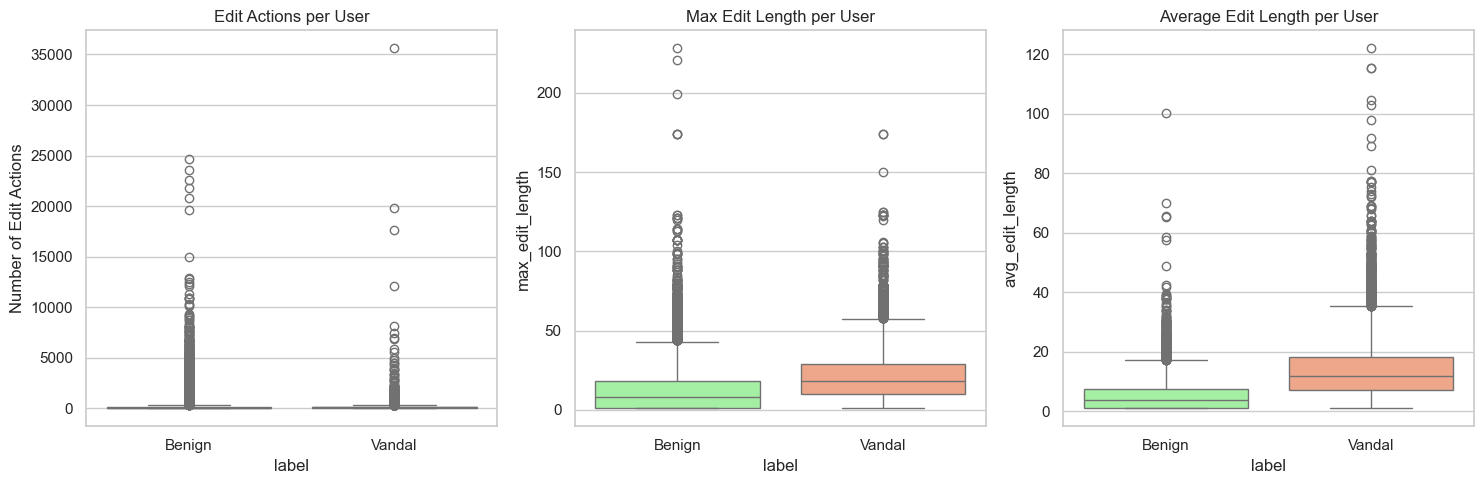

In [53]:
# Edit sequence analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="label", y="flattened_edit_len", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Edit Actions per User")
plt.ylabel("Number of Edit Actions")

plt.subplot(1, 3, 2)
sns.boxplot(x="label", y="max_edit_length", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Max Edit Length per User")

plt.subplot(1, 3, 3)
sns.boxplot(x="label", y="avg_edit_length", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Average Edit Length per User")

plt.tight_layout()
plt.show()

## Revert Pattern Analysis

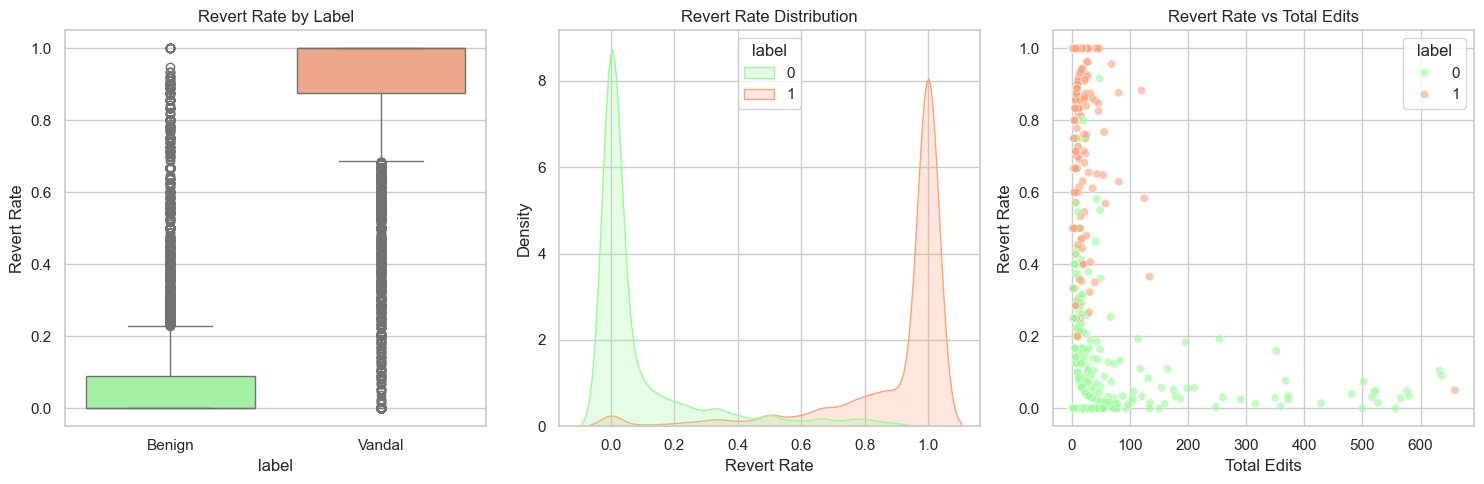

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="label", y="revert_rate", data=df, palette=[non_revert_color, revert_color])
plt.xticks([0, 1], ["Benign", "Vandal"])
plt.title("Revert Rate by Label")
plt.ylabel("Revert Rate")

plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x="revert_rate", hue="label", fill=True, common_norm=False, 
            palette=[non_revert_color, revert_color])
plt.title("Revert Rate Distribution")
plt.xlabel("Revert Rate")

plt.subplot(1, 3, 3)
# Revert rate vs total edits
sns.scatterplot(data=df.sample(1000), x="total_edits", y="revert_rate", 
                hue="label", palette=[non_revert_color, revert_color], alpha=0.6)
plt.title("Revert Rate vs Total Edits")
plt.xlabel("Total Edits")
plt.ylabel("Revert Rate")

plt.tight_layout()
plt.show()

## Feature Correlations

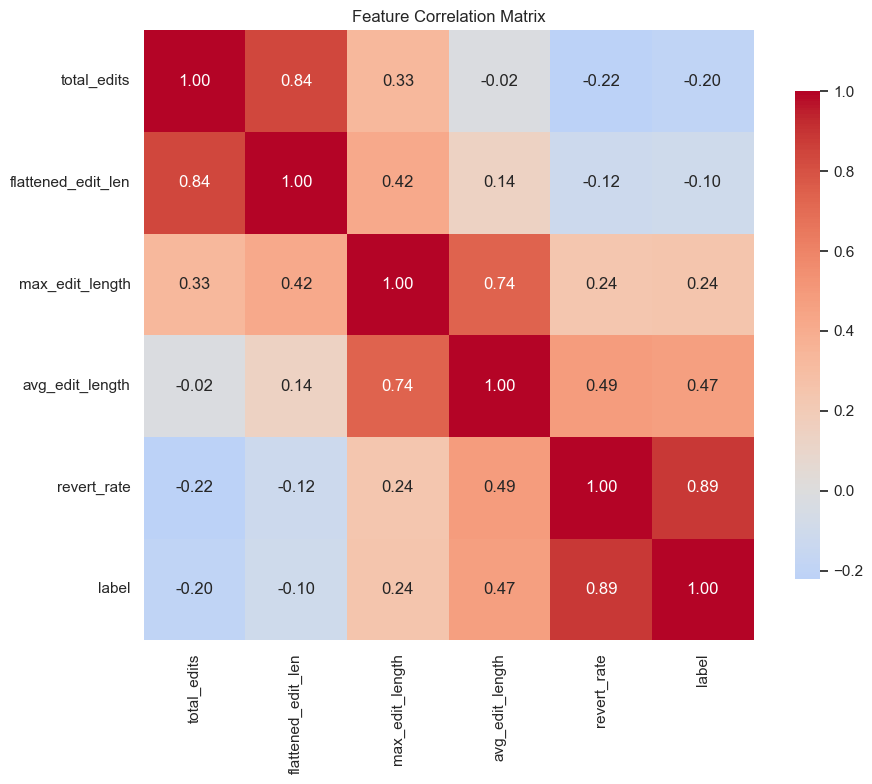

In [55]:
# Correlation matrix for numerical features
numerical_cols = ['total_edits', 'flattened_edit_len', 'max_edit_length', 'avg_edit_length', 'revert_rate', 'label']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Statistical Summary

In [56]:
# Summary statistics by label
summary_cols = ['total_edits', 'flattened_edit_len', 'max_edit_length', 'avg_edit_length', 'revert_rate']

for col in summary_cols:
    print(f"\n{'='*50}")
    print(f"Summary Statistics: {col.replace('_', ' ').title()}")
    print(f"{'='*50}")
    summary = df.groupby("label")[col].describe()
    summary.index = ['Benign', 'Vandal']
    print(summary)
    
    # Statistical test (Mann-Whitney U test for non-parametric comparison)
    from scipy.stats import mannwhitneyu
    benign_data = df[df['label'] == 0][col].dropna()
    vandal_data = df[df['label'] == 1][col].dropna()
    
    if len(benign_data) > 0 and len(vandal_data) > 0:
        statistic, p_value = mannwhitneyu(benign_data, vandal_data, alternative='two-sided')
        print(f"\nMann-Whitney U test p-value: {p_value:.2e}")
        print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")


Summary Statistics: Total Edits
          count       mean        std  min  25%  50%   75%     max
Benign   9897.0  40.319693  95.444658  1.0  4.0  9.0  28.0   992.0
Vandal  10209.0  10.921638  37.765940  1.0  4.0  6.0  11.0  2603.0

Mann-Whitney U test p-value: 1.42e-154
Statistically significant difference: Yes

Summary Statistics: Flattened Edit Len
          count        mean          std  min   25%   50%    75%      max
Benign   9897.0  321.321815  1110.396903  1.0   8.0  35.0  152.0  24617.0
Vandal  10209.0  148.334607   536.457917  1.0  34.0  76.0  156.0  35600.0

Mann-Whitney U test p-value: 1.56e-162
Statistically significant difference: Yes

Summary Statistics: Max Edit Length
          count       mean        std  min   25%   50%   75%    max
Benign   9897.0  13.388299  16.358358  1.0   1.0   8.0  18.0  228.0
Vandal  10209.0  21.482026  16.006186  1.0  10.0  18.0  29.0  174.0

Mann-Whitney U test p-value: 0.00e+00
Statistically significant difference: Yes

Summary Statistic

## Key Insights

Based on the analysis above, we can observe several patterns that distinguish vandal users from benign users in Wikipedia editing behavior.

In [57]:
# Key insights calculation
benign_users = df[df['label'] == 0]
vandal_users = df[df['label'] == 1]

print("KEY INSIGHTS:")
print("=" * 50)

print(f"1. Dataset Balance:")
print(f"   - Benign users: {len(benign_users):,} ({len(benign_users)/len(df)*100:.1f}%)")
print(f"   - Vandal users: {len(vandal_users):,} ({len(vandal_users)/len(df)*100:.1f}%)")

print(f"\n2. Edit Activity:")
print(f"   - Median edits (Benign): {benign_users['total_edits'].median():.0f}")
print(f"   - Median edits (Vandal): {vandal_users['total_edits'].median():.0f}")

print(f"\n3. Revert Patterns:")
print(f"   - Avg revert rate (Benign): {benign_users['revert_rate'].mean():.3f}")
print(f"   - Avg revert rate (Vandal): {vandal_users['revert_rate'].mean():.3f}")

print(f"\n4. Edit Complexity:")
print(f"   - Avg edit length (Benign): {benign_users['avg_edit_length'].mean():.1f}")
print(f"   - Avg edit length (Vandal): {vandal_users['avg_edit_length'].mean():.1f}")

print(f"\n5. Most Discriminative Features:")
feature_importance = abs(corr_matrix['label'].drop('label')).sort_values(ascending=False)
for i, (feature, correlation) in enumerate(feature_importance.head(3).items()):
    print(f"   {i+1}. {feature}: {correlation:.3f}")

KEY INSIGHTS:
1. Dataset Balance:
   - Benign users: 9,897 (49.2%)
   - Vandal users: 10,209 (50.8%)

2. Edit Activity:
   - Median edits (Benign): 9
   - Median edits (Vandal): 6

3. Revert Patterns:
   - Avg revert rate (Benign): 0.097
   - Avg revert rate (Vandal): 0.893

4. Edit Complexity:
   - Avg edit length (Benign): 5.3
   - Avg edit length (Vandal): 14.0

5. Most Discriminative Features:
   1. revert_rate: 0.889
   2. avg_edit_length: 0.472
   3. max_edit_length: 0.243
